In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.gridspec as gridspec
from scipy.cluster import hierarchy

import matplotlib as mpl
mpl.style.use('seaborn')
%matplotlib inline

In [28]:
cuentas=["@ClaudiaLopez","@carlosfgalan","@angelamrobledo","@MiguelUribeT","@angelagarzonc",
         "@luchogarzon","@hollmanmorris","@MAndreaNieto","@CelioNievesH","@jerojasrodrigue",
         "@LuisErnestoGL"]


# Loader


In [3]:
#get users and mentions from the download files:
tweets_datas_path = ["candidatos_alcaldia_0.json",
                     "candidatos_alcaldia_1.json"]
tw_id=[]
tw_user_id=[]
tw_user=[]
tw_text=[]
entities_long=[]
mentioned_ids=[]
tw_device=[]# print(twits[rnd_ind]["source"])
tw_date=[]# print(twits[rnd_ind]["created_at"])


for json_file in tweets_datas_path:
    with open(json_file, "r") as tweets_file:
        for line in tweets_file:
            try:
                tweet = json.loads(line)
                tw_entities=[]
                tw_entities.extend(tweet["entities"]["user_mentions"])
                entities_long.extend(tweet["entities"]["user_mentions"])
                tw_text_loop=[tweet["text"]]
                if tweet["truncated"]:#=="True": # Truncated indica si el tweet es corto o largo; si truncado, busca extendido
                    tw_text_loop=[tweet["extended_tweet"]["full_text"]]
                    tw_entities.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                    entities_long.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                else:
                    if tweet["text"][0:2]=="RT":
                        if tweet["retweeted_status"]["truncated"]:
                            tw_text_loop=[tweet["retweeted_status"]["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                        else: 
                            tw_text_loop=[tweet["retweeted_status"]["text"]]
                            tw_entities.extend(tweet["retweeted_status"]["entities"]["user_mentions"])
                        if tweet["retweeted_status"]["is_quote_status"]:
                            tw_text_loop=[tweet["retweeted_status"]["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                    else:
                        tw_text_loop=[tweet["text"]]
                tw_id.append(tweet["id_str"])
                tw_user_id.append(tweet["user"]["id_str"])
                tw_user.append(tweet["user"]["screen_name"])
                mentioned_ids.append([tweet["id_str"],tweet["user"]["id_str"],list(set([ent["id_str"] for ent in tw_entities]))])
                tw_text.append([tweet["id_str"],tw_text_loop[0]])
                tw_device.append(tweet["source"])
                tw_date.append(tweet["created_at"])
            except:
                continue

In [4]:
print("Tweets identificados con código     :",len(tw_id),"\n",
      "Tweets con usuario identificado     :",len(tw_user_id),"\n",
      "Tweets con nombre de usuario        :",len(tw_user),"\n",
      "Textos de tweets recuperados        :",len(tw_text),"\n",
      "Total de Menciones en los tweets    :",len(entities_long),"\n",
      "Tweets con menciones identificadas  :",len(mentioned_ids),"\n",
      "Tweets con dispositivos registrado  :",len(tw_device),"\n",
      "Tweets con fechas registradas       :",len(tw_date),"\n"
     )

Tweets identificados con código     : 241552 
 Tweets con usuario identificado     : 241552 
 Tweets con nombre de usuario        : 241552 
 Textos de tweets recuperados        : 241552 
 Total de Menciones en los tweets    : 1431219 
 Tweets con menciones identificadas  : 241552 
 Tweets con dispositivos registrado  : 241552 
 Tweets con fechas registradas       : 241552 



In [5]:
#tw_text=np.array(tw_text)

## tablas de menciones


In [6]:
ments_df=pd.DataFrame([[entit["id_str"],
                        entit["screen_name"],
                        entit["name"]
                       ]for entit in entities_long],
                     columns=["id_str","screen_name","name"])

In [7]:
ments_freq=pd.crosstab(index=ments_df.screen_name, columns="count")
ments_freq=ments_freq.sort_values(by=['count'] , ascending=False)
print("Cuentas mencionadas",ments_freq.shape[0])

Cuentas mencionadas 19680


In [37]:
# Tabla de ocurrencia de menciones por tuit
id_ments=pd.crosstab(np.array([tw_mnt for tw_mntns in mentioned_ids for tw_mnt in tw_mntns[2] ]), columns="count").sort_values(ascending=False, by="count")
# se utiliza el código para evitar conteos por homónimos

In [36]:
id_ments.head()

col_0,count
row_0,
137908875,117035
165748292,43377
49849732,38708
163341528,37506
87266285,20925


In [9]:
top_n=150

In [10]:
ments_ids_top=list(id_ments.index[:top_n])

In [31]:
mntns_top_ocurr=np.array([[cand in tw_mntns[2] for cand in ments_ids_top]for tw_mntns in mentioned_ids])
mntns_candts=np.array([[cand in tw_mntns[2] for cand in cuentas]for tw_mntns in mentioned_ids])

In [32]:
print(mntns_top_ocurr.shape)
print(mntns_candts.shape)

(241552, 150)
(241552, 11)


In [13]:
names_mnts_top=[]
for usr_id in id_ments.index[:top_n]:
    name=""
    try:
        name=ments_df[ments_df.id_str==usr_id].screen_name.iloc[0]
    except:
        name="Unknown"
#     print(usr_id, name)
    names_mnts_top.append(name)
        
#     print(usr_id,tweets_ids[tweets_ids.tw_user_id==usr_id].tw_user.iloc[0])

In [34]:
# twtxt_ids=[txt_id[0] for txt_id in tw_text] # Id del tuit con el texto
df_mntns_top_ocurr=pd.DataFrame(mntns_top_ocurr,columns=names_mnts_top, index=tw_id)
df_mntns_candts=pd.DataFrame(mntns_candts,columns=names_mnts_top, index=tw_id)

ValueError: Shape of passed values is (11, 241552), indices imply (150, 241552)

In [33]:
df_mntns_top_ocurr.shape

(241552, 150)

In [15]:
tweets_ids=pd.DataFrame({"tw_user_id":tw_user_id,"tw_user":tw_user}, index=tw_id)
ids_freqs=pd.crosstab(index=tweets_ids.tw_user, columns="count")
ids_freqs=ids_freqs.sort_values(by=['count'] , ascending=False)["count"]
print("twiteros:",ids_freqs.shape[0])

twiteros: 52827


row_0
<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>    147614
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>       53823
<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>                  18450
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       17032
<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>         3429
<a href="https://www.pyphoy.com/" rel="nofollow">Pypbot</a>                                464
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>        417
<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M2)</a>                    107
<a href="http://www.facebook.com/twitter" rel="nofollow">Facebook</a>                       27
<a href="https://paper.li" rel="nofollow">Paper.li</a>                                      26
<a href="http://www.tweetcaster.com" rel="no

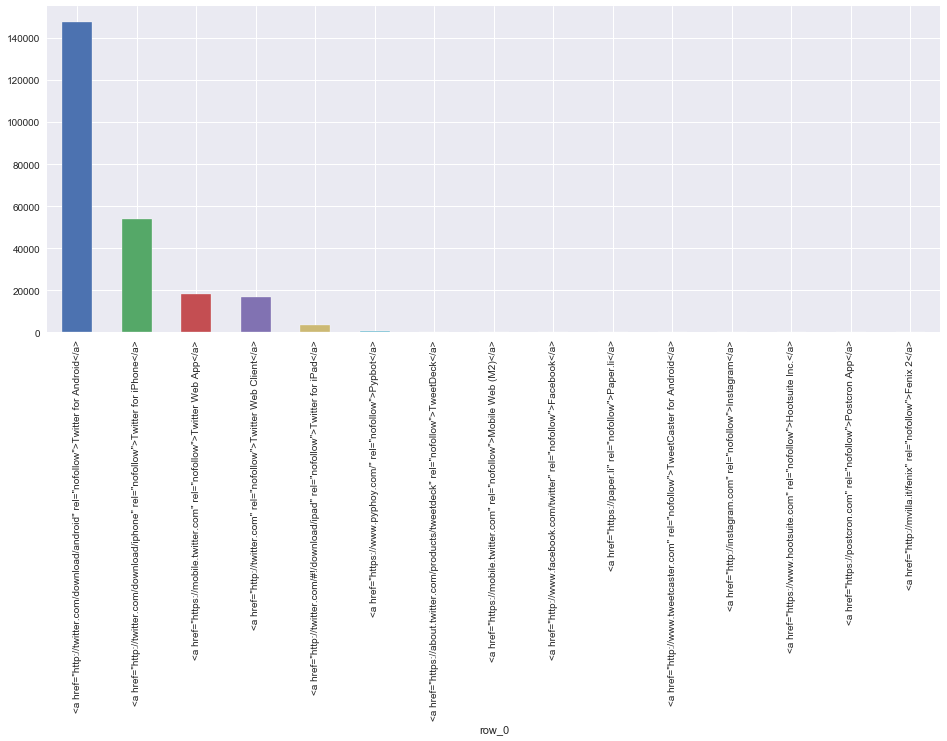

In [16]:
devices=pd.crosstab(index=np.array(tw_device), columns="count")
devices=devices.sort_values(by=['count'] , ascending=False)["count"]
devices[:15].plot(figsize=(16, 6), kind="bar")
devices[:15]

C:\Users\Alexis\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


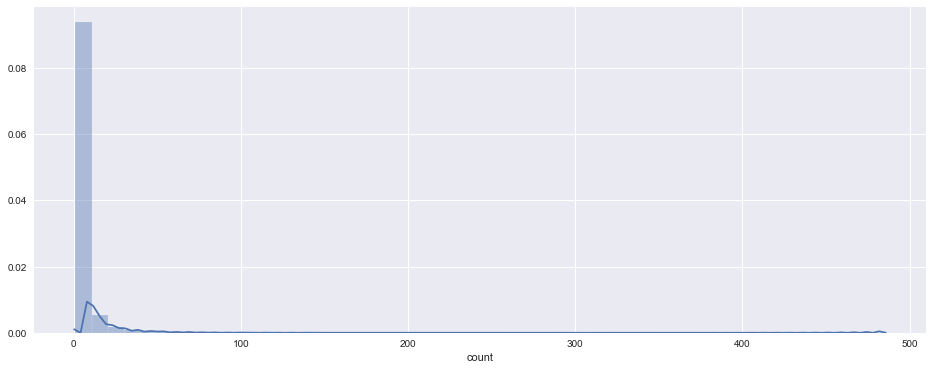

In [17]:
plt.figure(figsize=(16,6))
sns.distplot(ids_freqs)

In [18]:
round(ids_freqs.describe(),3)

count    52827.000
mean         4.573
std         11.272
min          1.000
25%          1.000
50%          2.000
75%          4.000
max        485.000
Name: count, dtype: float64

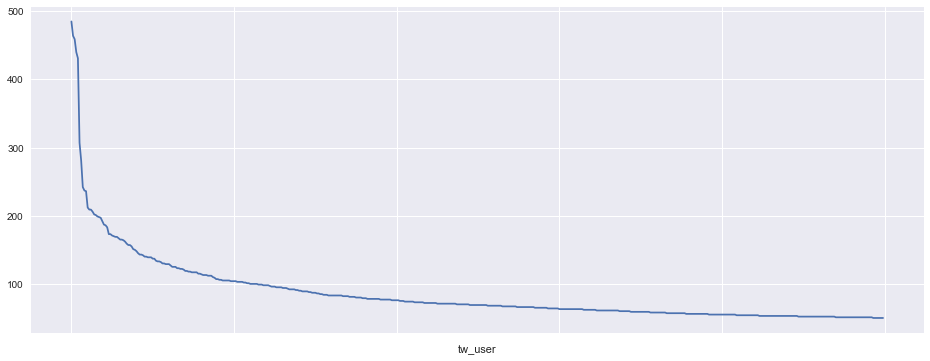

In [19]:
ids_freqs[:500].plot(figsize=(16, 6))

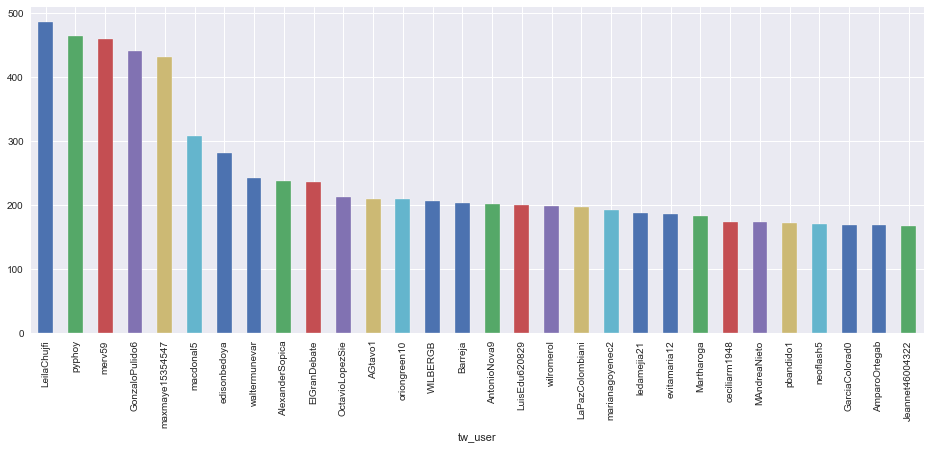

In [20]:
ids_freqs[:30].plot(figsize=(16, 6), kind="bar")
plt.savefig('top_tweeters.png')

In [21]:
ids_freqs.sort_values(ascending=False)[:60]

tw_user
LeilaChujfi        485
pyphoy             464
merv59             459
GonzaloPulido6     440
maxmaye15354547    431
macdonal5          307
edisonbedoya       281
waltermunevar      242
AlexanderSopica    237
ElGranDebate       236
OctavioLopezSie    212
oriongreen10       209
AGtavo1            209
WILBERGB           206
Barreja            202
AntonioNova9       201
LuisEdu620829      199
wilromerol         198
LaPazColombiani    197
marianagoyenec2    192
ledamejia21        187
evitamaria12       186
Martharoga         183
ceciliarm1948      173
MAndreaNieto       173
pbandido1          171
neoflash5          170
GarciaColorad0     169
AmparoOrtegab      169
Jeannet46004322    167
HellennDeTroya     165
ktina_mejia        165
helmanzano         164
WILSONRUIZRUIZ1    162
pierrealee         159
YehiniCarolina     157
Monyrica           157
lusecitagomes      155
CarlosCarrilloA    151
patricita5758      150
WinchesterMusk     148
GNavasTalero       145
CastellEd          143
rmo

In [22]:
uniq_ids=list(set([entit["id_str"]for entit in entities_long]))
len(uniq_ids)

19633

ClaudiaLopez       117035
angelamrobledo      43377
petrogustavo        38708
MiguelUribeT        37506
HOLLMANMORRIS       20925
GustavoBolivar      17797
angelagarzonc       15956
IvanDuque           14811
EnriquePenalosa     14365
CConstitucional     12824
jerojasrodrigue     11488
carlosfgalan        11026
AidaAvellaE          9358
PizarroMariaJo       9347
LuisErnestoGL        9026
AngelicaLozanoC      8502
GNavasTalero         8397
DavidRacero          8108
merv59               7749
CarlosCarrilloA      7471
dtype: int64


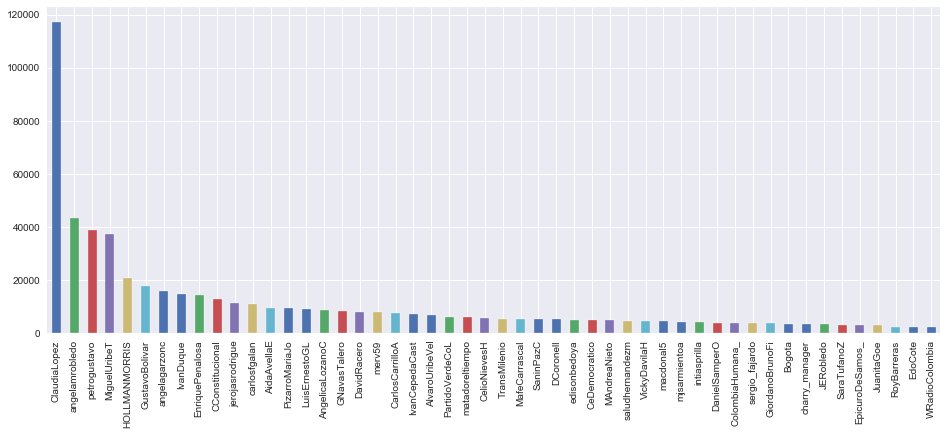

In [23]:
plt.figure(figsize=(16,6))
print (df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:20])
df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:50].plot(kind="bar")
plt.savefig('top_mentions.png')

# Relaciones de cuentas

In [24]:
directed_graph_df=df_mntns_top_ocurr.groupby(tw_user).aggregate(sum)

In [30]:
mat_dendr=directed_graph_df.loc[directed_graph_df.sum(axis=1).sort_values(ascending=False)[:500].index,:]
# mat_dendr_candts=directed_graph_df.loc[directed_graph_df.sum(axis=1).sort_values(ascending=False)[:500].index,cuentas]

In [27]:
mat_dendr

,ClaudiaLopez,angelamrobledo,petrogustavo,MiguelUribeT,HOLLMANMORRIS,GustavoBolivar,angelagarzonc,IvanDuque,EnriquePenalosa,CConstitucional,...,pierrealee,JAntiuribista,FuerzasMilCol,Marianiniecheve,CARLOSFMEJIA,arfisica,BluRadioCo,MaFeRojas,Lynx_Arya,afgarcialo
LeilaChujfi,54.0,381.0,70.0,9.0,22.0,286.0,0.0,67.0,7.0,0.0,...,0.0,239.0,229.0,93.0,1.0,0.0,0.0,0.0,6.0,5.0
merv59,32.0,359.0,260.0,4.0,13.0,289.0,1.0,49.0,1.0,0.0,...,1.0,64.0,58.0,33.0,0.0,4.0,0.0,0.0,29.0,0.0
edisonbedoya,1.0,278.0,265.0,0.0,0.0,258.0,0.0,23.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,0.0
macdonal5,81.0,161.0,168.0,13.0,13.0,142.0,9.0,27.0,7.0,0.0,...,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,12.0,0.0
maxmaye15354547,156.0,22.0,59.0,45.0,99.0,20.0,12.0,2.0,79.0,0.0,...,0.0,0.0,0.0,16.0,0.0,0.0,3.0,11.0,2.0,8.0
carlopoc7,0.0,129.0,2.0,0.0,2.0,128.0,0.0,0.0,0.0,0.0,...,0.0,128.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pierrealee,4.0,151.0,151.0,0.0,4.0,150.0,0.0,1.0,1.0,0.0,...,151.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
GonzaloPulido6,120.0,58.0,98.0,54.0,232.0,25.0,1.0,9.0,90.0,3.0,...,0.0,0.0,0.0,4.0,0.0,0.0,1.0,5.0,4.0,17.0
afgarcialo,134.0,0.0,136.0,0.0,135.0,134.0,0.0,0.0,135.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
LuisEdu620829,21.0,105.0,39.0,1.0,8.0,15.0,0.0,9.0,1.0,0.0,...,0.0,4.0,0.0,111.0,1.0,0.0,0.0,0.0,20.0,0.0


# Temporalidad

In [24]:
tw_fechas_df=pd.DataFrame(np.column_stack([tw_user,tw_date]))
tw_fechas_df.columns=["user","date_tweet"]
tw_fechas_df["date_tweet"]=pd.to_datetime(tw_fechas_df['date_tweet'], utc=True)#.tz_convert('US/Eastern')
tw_fechas_df.set_index('date_tweet', inplace=True)#.tz_convert('US/Eastern')
tw_fechas_df.index=tw_fechas_df.index.tz_convert('Etc/GMT+5')
tw_fechas_df["ocurr"]=1

In [25]:
time_sample="900S"#"3600s"#'1440T'

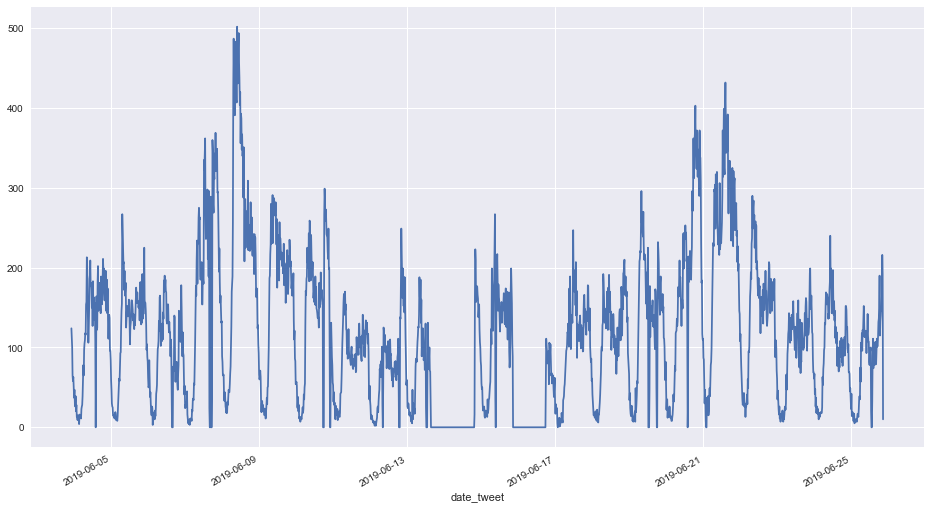

In [26]:
plt.figure(figsize=(16,9))
tw_fechas_df.ocurr.resample(time_sample).sum().plot()#kind="bar")

In [27]:
mayor_tweeters=list(directed_graph_df.sum(axis=1).sort_values(ascending=False).index[:10])

In [28]:
tw_fechas_df_top=tw_fechas_df[tw_fechas_df.user.isin(mayor_tweeters)]
#tw_fechas_df_filt.head(20)

In [29]:
twits_filt=pd.crosstab(index=tw_fechas_df_top.index,
                  columns=tw_fechas_df_top["user"])
twits_filt=twits_filt.resample(time_sample).sum()

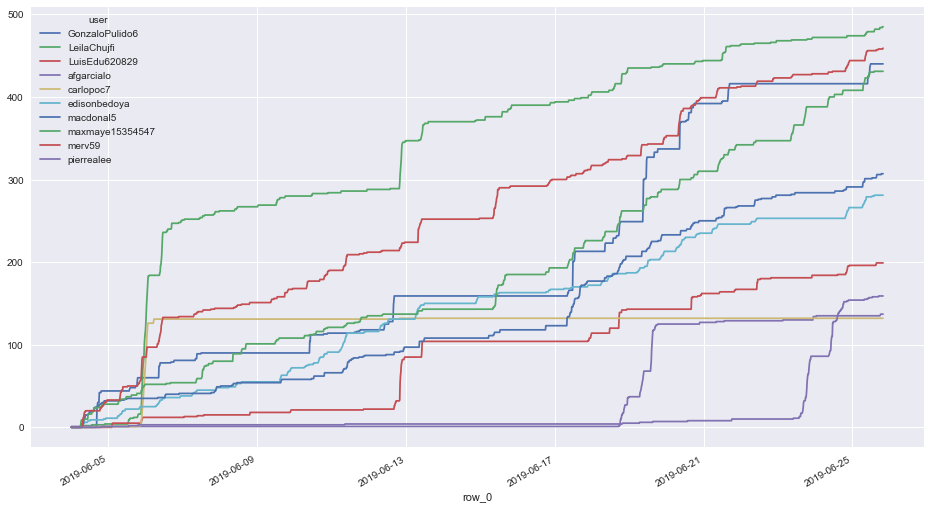

In [30]:
twits_filt.cumsum().plot(figsize=(16,9))

In [31]:
top_ments_df=df_mntns_top_ocurr.copy()*1
top_ments_df.index=tw_fechas_df.index
# top_ments_df.head(20)

In [32]:
top_ments_df_day=top_ments_df.iloc[:,:10].resample(time_sample).sum()

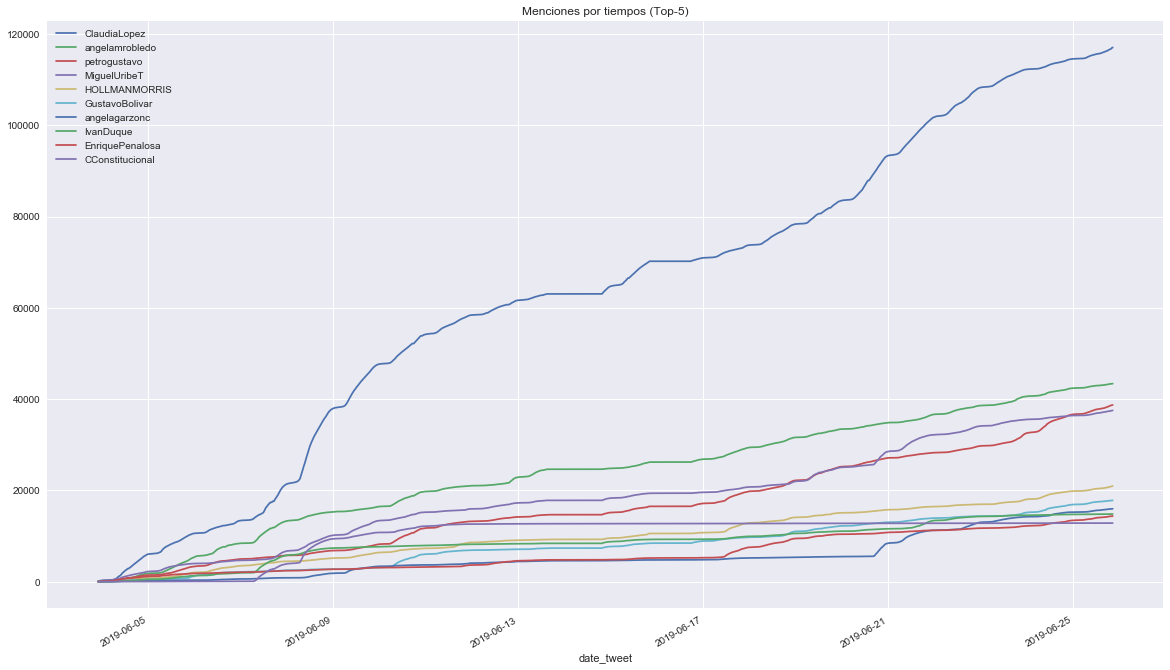

In [33]:
top_ments_df_day.cumsum().plot(figsize=(20,12), title="Menciones por tiempos (Top-5)")

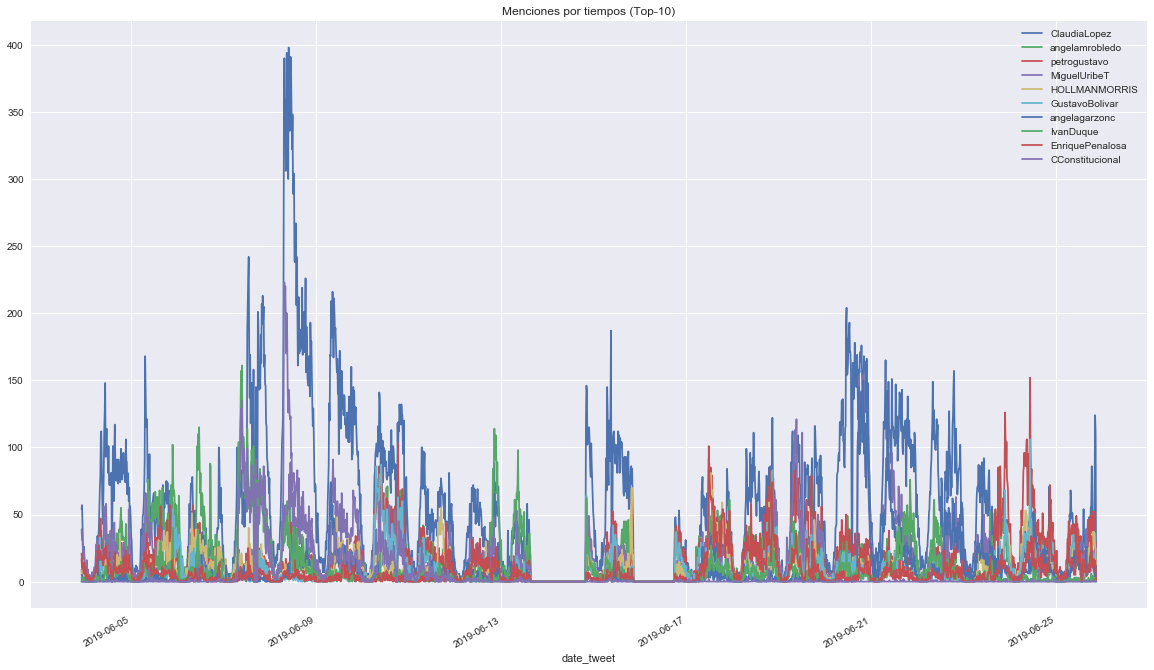

In [34]:
top_ments_df_day.plot(figsize=(20,12), title="Menciones por tiempos (Top-10)")

# Grafos

In [35]:
mat_size=40
graph_mat=directed_graph_df.loc[directed_graph_df.sum(axis=1).sort_values(ascending=False).index[:mat_size],
                                directed_graph_df.sum(axis=0).sort_values(ascending=False).index[:mat_size]
                               ]
graph_mat.head()

,ClaudiaLopez,angelamrobledo,petrogustavo,MiguelUribeT,HOLLMANMORRIS,GustavoBolivar,angelagarzonc,IvanDuque,EnriquePenalosa,CConstitucional,...,CeDemocratico,MAndreaNieto,saludhernandezm,VickyDavilaH,macdonal5,mjsarmientoa,intiasprilla,DanielSamperO,ColombiaHumana_,sergio_fajardo
LeilaChujfi,54.0,381.0,70.0,9.0,22.0,286.0,0.0,67.0,7.0,0.0,...,2.0,0.0,0.0,0.0,12.0,0.0,1.0,30.0,8.0,6.0
merv59,32.0,359.0,260.0,4.0,13.0,289.0,1.0,49.0,1.0,0.0,...,22.0,0.0,0.0,22.0,209.0,0.0,11.0,29.0,4.0,7.0
edisonbedoya,1.0,278.0,265.0,0.0,0.0,258.0,0.0,23.0,0.0,0.0,...,20.0,0.0,0.0,5.0,234.0,0.0,4.0,0.0,0.0,3.0
macdonal5,81.0,161.0,168.0,13.0,13.0,142.0,9.0,27.0,7.0,0.0,...,14.0,0.0,0.0,30.0,240.0,3.0,18.0,1.0,1.0,53.0
maxmaye15354547,156.0,22.0,59.0,45.0,99.0,20.0,12.0,2.0,79.0,0.0,...,1.0,0.0,0.0,0.0,1.0,70.0,12.0,15.0,22.0,1.0


In [36]:
graph_df=graph_mat.melt()
graph_df.columns=["tw_para", "freq"]
graph_df["tw_de"]=[usr for i in range(int(len(graph_df)/len(graph_mat.index)))for usr in list(graph_mat.index)]
graph_df=graph_df.loc[:,["tw_de","tw_para","freq"]]

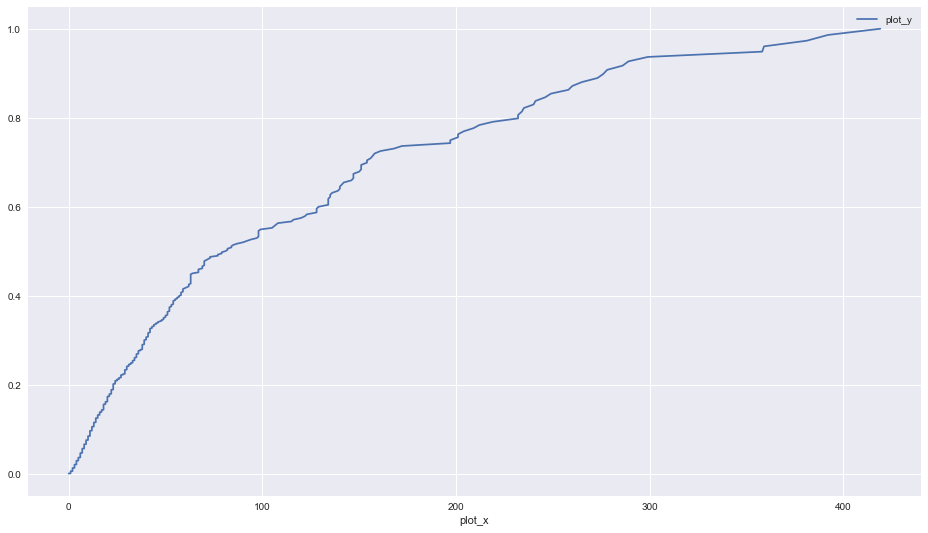

In [37]:
plot_x=np.array(list(graph_df.freq.sort_values(ascending=True)))
plot_y=np.cumsum(plot_x)/sum(plot_x)
cum_freq=pd.DataFrame({"plot_x":plot_x,
                       "plot_y":plot_y})
cum_freq.plot(x="plot_x",
              y="plot_y",
             figsize=(16,9))

In [38]:
min_crit_tw=cum_freq[cum_freq.plot_y>=.3].iloc[0,0]
graph_df_filt=graph_df.loc[graph_df.freq>=min_crit_tw,:]
mx_fr=max(graph_df_filt.freq)
print(min_crit_tw)
print(len(graph_df_filt))
graph_df_filt.sort_values("freq",ascending=False)#.head(20)

40.0
196


,tw_de,tw_para,freq
19,pyphoy,ClaudiaLopez,419.0
721,merv59,merv59,392.0
40,LeilaChujfi,angelamrobledo,381.0
41,merv59,angelamrobledo,359.0
720,LeilaChujfi,merv59,358.0
481,merv59,AidaAvellaE,299.0
201,merv59,GustavoBolivar,289.0
200,LeilaChujfi,GustavoBolivar,286.0
42,edisonbedoya,angelamrobledo,278.0
482,edisonbedoya,AidaAvellaE,276.0


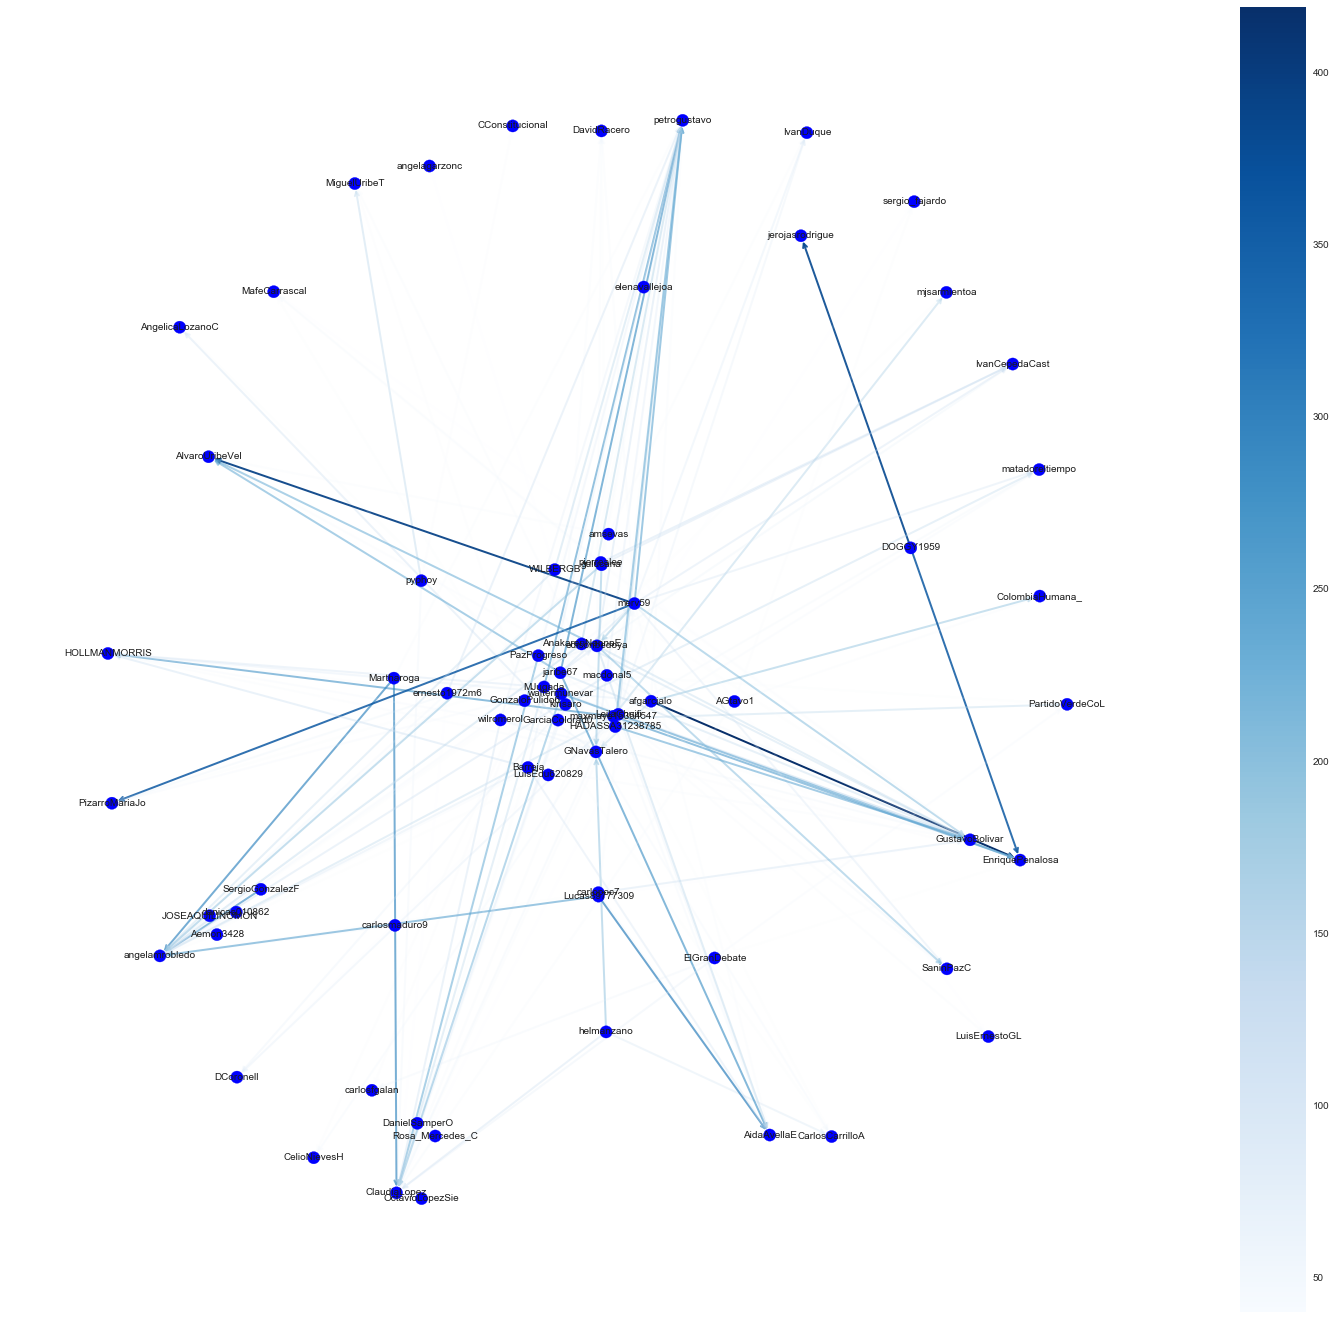

In [39]:
plt.figure(figsize=(26,24))
G= nx.DiGraph()#nx.generators.directed.random_k_out_graph(10, 3, 0.5)
for i, elrow in graph_df_filt.iterrows():
    G.add_edge(elrow[0], elrow[1])

pos = nx.layout.spring_layout(G)

node_sizes = [150 for i in range(len(G))]
M = G.number_of_edges()
edge_colors =[fr for fr in graph_df_filt.freq]#range(2, M + 2)
edge_alphas =[fr/mx_fr for fr in graph_df_filt.freq]#[fr/mx_fr for fr in graph_df_filt.freq]#[(5 + i) / (M + 4) for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue')
edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=10, edge_color=edge_colors,
                               edge_cmap=plt.cm.Blues, width=2)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

nx.draw_networkx_labels(G, pos, font_size=10)

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [40]:
g = nx.Graph()

In [41]:
for i, elrow in graph_df_filt.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

In [42]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))

# of edges: 193
# of nodes: 70


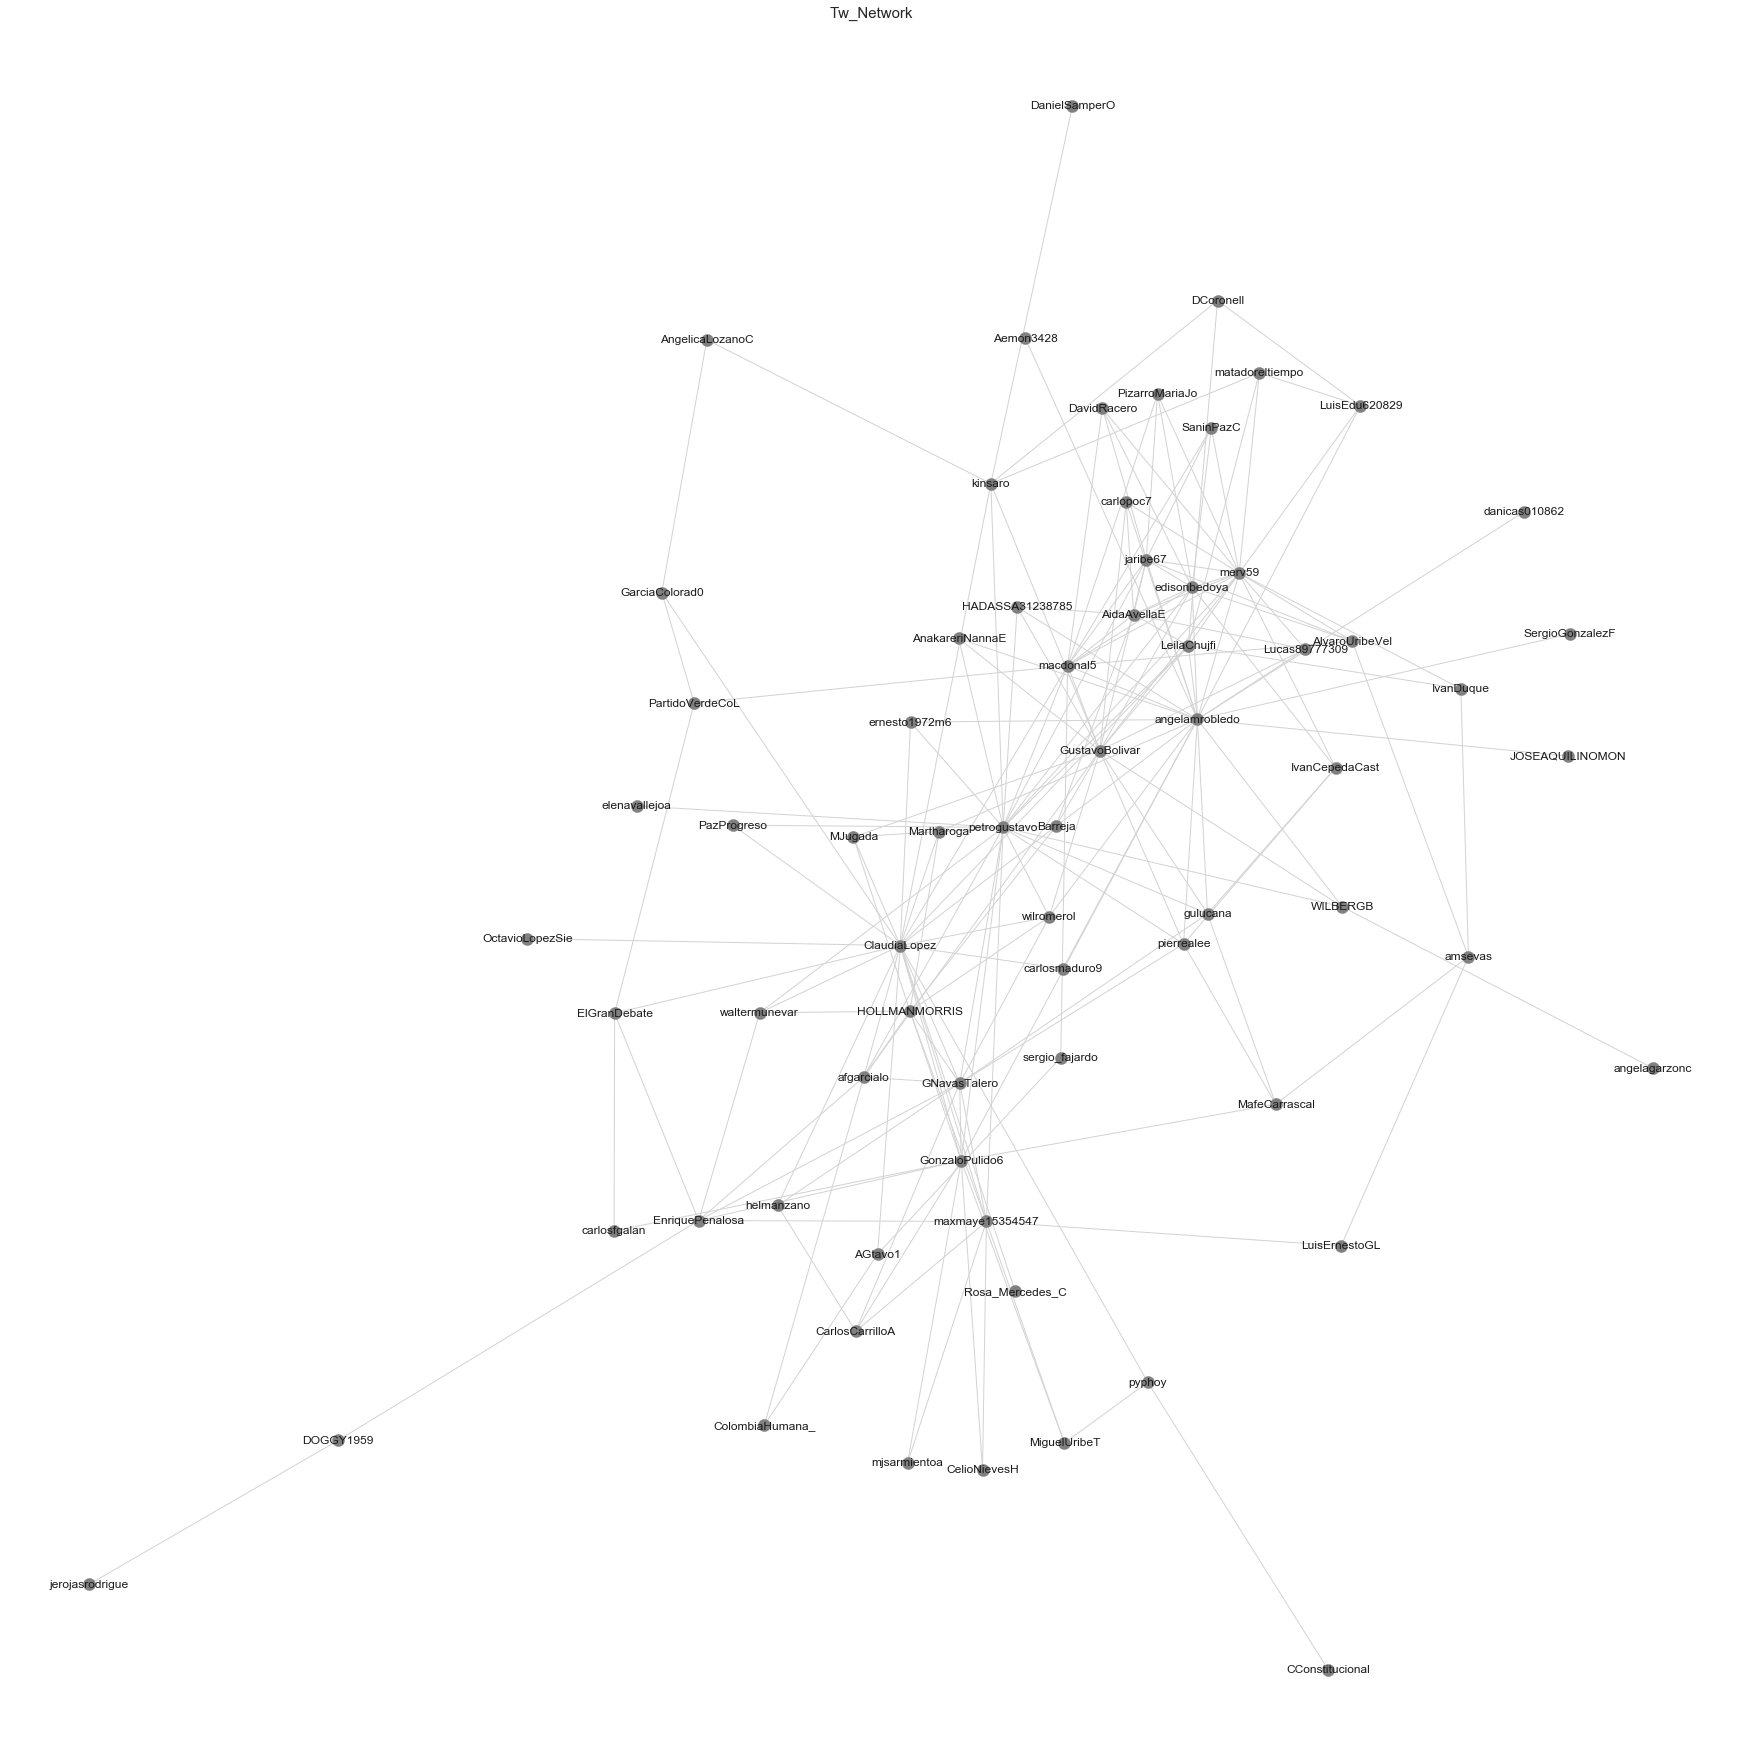

In [43]:
plt.figure(figsize=(24, 24))
nx.draw(g,
        node_size=150,
        edge_color='lightgray',
        node_color='gray',
        with_labels=True)
plt.title('Tw_Network', size=15)
plt.show()
# plt.savefig('tweets_net.png')